[INFO] Kelas F: 300 file
[OK] Kelas F selesai disimpan ke dataset_ecg_encoded/F
[INFO] Kelas N: 300 file
[OK] Kelas N selesai disimpan ke dataset_ecg_encoded/N
[INFO] Kelas Q: 300 file
[OK] Kelas Q selesai disimpan ke dataset_ecg_encoded/Q
[INFO] Kelas S: 300 file
[OK] Kelas S selesai disimpan ke dataset_ecg_encoded/S
[INFO] Kelas V: 300 file
[OK] Kelas V selesai disimpan ke dataset_ecg_encoded/V

[DONE] Semua kelas selesai di-encode dan disimpan.


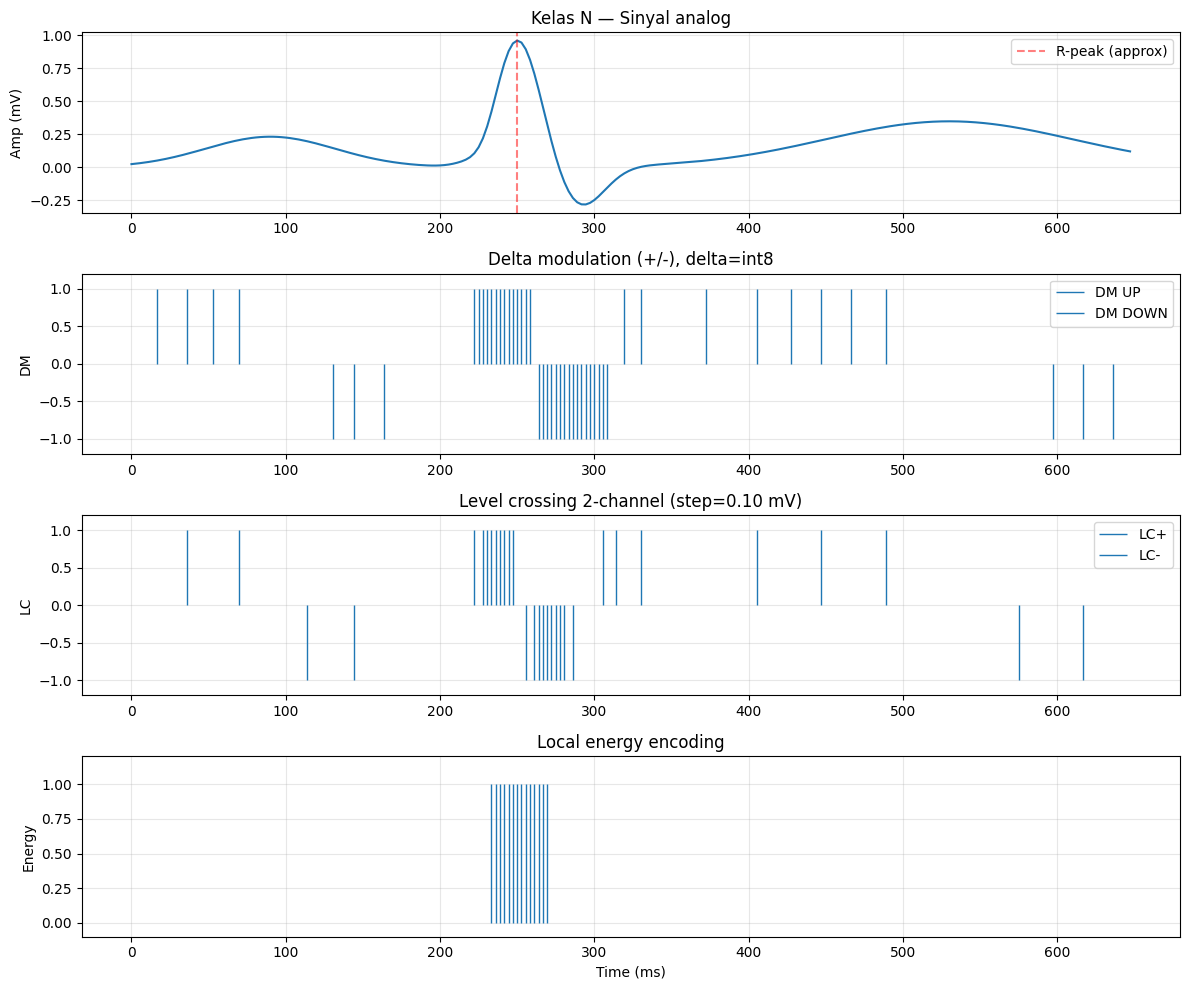

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# 1. Spike encoding methods
# ============================================================

def encode_delta_modulation(x: np.ndarray, delta: float = 0.05):
    """
    Delta modulation +/-
    - dm_up[n]   = 1 jika x[n] - y[n-1] >  delta
    - dm_down[n] = 1 jika x[n] - y[n-1] < -delta

    y[n] adalah sinyal rekonstruksi DM.
    """
    x = np.asarray(x)
    N = x.size

    y = np.zeros(N, dtype=float)
    up = np.zeros(N, dtype=np.int8)
    down = np.zeros(N, dtype=np.int8)

    for n in range(1, N):
        err = x[n] - y[n - 1]
        if err > delta:
            up[n] = 1
            y[n] = y[n - 1] + delta
        elif err < -delta:
            down[n] = 1
            y[n] = y[n - 1] - delta
        else:
            y[n] = y[n - 1]

    return up, down


def encode_level_crossing_2ch(
    x: np.ndarray,
    step_mv: float = 0.1,
):
    """
    Level crossing 2-channel (LC+ dan LC-), dengan grid tiap 'step_mv' mV.

    Ide:
    - Kuantisasi sinyal ke index level: idx[n] = floor(x[n] / step_mv)
    - Kalau idx naik (idx[n] > idx[n-1]) → ada crossing ke atas → lc_up[n] = 1
    - Kalau idx turun (idx[n] < idx[n-1]) → ada crossing ke bawah → lc_down[n] = 1
    - Tidak dipisah per level, hanya 2 channel global.

    Return:
        lc_up   : (T,)
        lc_down : (T,)
        step_mv : float
    """
    x = np.asarray(x)
    N = x.size

    # index level (bisa negatif)
    idx = np.floor(x / step_mv).astype(int)

    up = np.zeros(N, dtype=np.int8)
    down = np.zeros(N, dtype=np.int8)

    for n in range(1, N):
        delta_idx = idx[n] - idx[n - 1]
        if delta_idx > 0:
            up[n] = 1       # ada crossing naik (bisa lebih dari satu level, tapi tetap 1)
        elif delta_idx < 0:
            down[n] = 1     # ada crossing turun

    return up, down, step_mv


def encode_local_energy(
    x: np.ndarray,
    window: int = 7,
    energy_thresh: float = 0.2,
):
    """
    Local energy encoding:
    - E[n] = sum_{k in window} x[n+k]^2
    - Spike jika E[n] > energy_thresh * max(E)
    """
    x = np.asarray(x)
    N = x.size
    half = window // 2
    energy = np.zeros(N, dtype=float)

    for n in range(N):
        i0 = max(0, n - half)
        i1 = min(N, n + half + 1)
        energy[n] = np.sum(x[i0:i1] ** 2)

    maxE = float(np.max(energy)) if np.max(energy) > 0 else 1.0
    thr = energy_thresh * maxE
    spikes = (energy > thr).astype(np.int8)
    return spikes


# ============================================================
# 2. Encode dataset: baca dari dataset_ecg, simpan ke dataset_ecg_encoded
# ============================================================

def encode_existing_dataset(
    input_dir: str,
    output_dir: str,
    dm_delta: float = 0.05,
    lc_step_mv: float = 0.1,
    energy_window: int = 7,
    energy_thresh: float = 0.2,
):
    """
    Baca semua beat *.npz dari input_dir (struktur per kelas),
    lakukan spike encoding, dan simpan ke output_dir dengan struktur sama.

    Asumsi format input (per file .npz):
      - signal: (T,)
      - t     : (T,)
      - label : str

    Format output (per file .npz):
      - signal        : (T,)
      - t             : (T,)
      - label         : str
      - fs            : float (dihitung dari t)
      - dm_up         : (T,)
      - dm_down       : (T,)
      - lc_up         : (T,)   (LC+)
      - lc_down       : (T,)   (LC-)
      - lc_step_mv    : float  (grid level, default 0.1 mV)
      - energy_spikes : (T,)
    """
    os.makedirs(output_dir, exist_ok=True)

    classes = [
        d for d in os.listdir(input_dir)
        if os.path.isdir(os.path.join(input_dir, d))
    ]
    classes.sort()

    for cls in classes:
        in_cls_dir = os.path.join(input_dir, cls)
        out_cls_dir = os.path.join(output_dir, cls)
        os.makedirs(out_cls_dir, exist_ok=True)

        files = sorted(
            f for f in os.listdir(in_cls_dir)
            if f.endswith(".npz")
        )

        print(f"[INFO] Kelas {cls}: {len(files)} file")

        for fname in files:
            in_path = os.path.join(in_cls_dir, fname)
            out_path = os.path.join(out_cls_dir, fname)

            data = np.load(in_path)
            signal = data["signal"].astype(np.float32)
            t = data["t"].astype(np.float32)
            label = str(data["label"])

            if t.size < 2:
                raise ValueError(f"Waktu t terlalu pendek di file {in_path}")
            dt = float(t[1] - t[0])
            fs = 1.0 / dt

            # ---------- Spike encodings ----------
            dm_up, dm_down = encode_delta_modulation(signal, delta=dm_delta)

            lc_up, lc_down, lc_step = encode_level_crossing_2ch(
                signal,
                step_mv=lc_step_mv,
            )

            energy_spikes = encode_local_energy(
                signal,
                window=energy_window,
                energy_thresh=energy_thresh,
            )

            # Simpan ke file baru
            np.savez(
                out_path,
                signal=signal,
                t=t,
                label=label,
                fs=fs,
                dm_up=dm_up,
                dm_down=dm_down,
                lc_up=lc_up,
                lc_down=lc_down,
                lc_step_mv=lc_step,
                energy_spikes=energy_spikes,
            )

        print(f"[OK] Kelas {cls} selesai disimpan ke {out_cls_dir}")

    print("\n[DONE] Semua kelas selesai di-encode dan disimpan.")


# ============================================================
# 3. Plot 1 sample: sinyal + hasil encoding
# ============================================================

def plot_example_encodings(
    base_dir: str,
    cls: str = "N",
    idx: int = 0,
):
    """
    Plot 1 contoh beat + tiga jenis encoding:
      - Delta modulation (+/-)
      - Level crossing 2-channel (+/-)
      - Local energy spikes

    base_dir: folder output encoding, misal "dataset_ecg_encoded"
    cls     : kelas, misal "N", "S", "V", "F", "Q"
    idx     : index beat, misal 0 untuk beat_0000.npz
    """
    cls = cls.upper()
    cls_dir = os.path.join(base_dir, cls)
    fname = os.path.join(cls_dir, f"beat_{idx:04d}.npz")
    if not os.path.isfile(fname):
        raise FileNotFoundError(f"File {fname} tidak ditemukan.")

    data = np.load(fname)
    signal = data["signal"]
    t = data["t"] * 1000.0  # ke ms
    dm_up = data["dm_up"]
    dm_down = data["dm_down"]
    lc_up = data["lc_up"]
    lc_down = data["lc_down"]
    energy_spikes = data["energy_spikes"]
    fs = float(data["fs"])
    lc_step_mv = float(data["lc_step_mv"])

    # Estimasi r_time dari posisi R (opsional, hanya untuk garis vertikal)
    r_idx = int(np.argmax(signal))
    r_time_ms = float(t[r_idx])

    fig = plt.figure(figsize=(12, 10))

    # 1) Sinyal analog
    ax1 = fig.add_subplot(4, 1, 1)
    ax1.plot(t, signal, linewidth=1.5)
    ax1.axvline(r_time_ms, linestyle="--", color="red", alpha=0.5, label="R-peak (approx)")
    ax1.set_ylabel("Amp (mV)")
    ax1.set_title(f"Kelas {cls} — Sinyal analog")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="upper right")

    # 2) Delta modulation
    ax2 = fig.add_subplot(4, 1, 2, sharex=ax1)
    up_idx = np.where(dm_up > 0)[0]
    down_idx = np.where(dm_down > 0)[0]
    ax2.vlines(t[up_idx], 0.0, 1.0, linewidth=1.0, label="DM UP")
    ax2.vlines(t[down_idx], -1.0, 0.0, linewidth=1.0, label="DM DOWN")
    ax2.set_ylim(-1.2, 1.2)
    ax2.set_ylabel("DM")
    ax2.set_title(f"Delta modulation (+/-), delta={dm_up.dtype}")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="upper right")

    # 3) Level crossing 2-channel
    ax3 = fig.add_subplot(4, 1, 3, sharex=ax1)
    lc_up_idx = np.where(lc_up > 0)[0]
    lc_down_idx = np.where(lc_down > 0)[0]
    ax3.vlines(t[lc_up_idx], 0.0, 1.0, linewidth=1.0, label="LC+")
    ax3.vlines(t[lc_down_idx], -1.0, 0.0, linewidth=1.0, label="LC-")
    ax3.set_ylim(-1.2, 1.2)
    ax3.set_ylabel("LC")
    ax3.set_title(f"Level crossing 2-channel (step={lc_step_mv:.2f} mV)")
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc="upper right")

    # 4) Local energy spikes
    ax4 = fig.add_subplot(4, 1, 4, sharex=ax1)
    spike_idx = np.where(energy_spikes > 0)[0]
    ax4.vlines(t[spike_idx], 0.0, 1.0, linewidth=1.0)
    ax4.set_ylim(-0.1, 1.2)
    ax4.set_ylabel("Energy")
    ax4.set_xlabel("Time (ms)")
    ax4.set_title("Local energy encoding")
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# ============================================================
# 4. Main
# ============================================================

if __name__ == "__main__":
    # Folder asal: hasil generate sebelumnya
    input_dir = "dataset_ecg"          # SESUAIKAN dengan folder hasil generatormu
    # Folder tujuan: hasil encoding
    output_dir = "dataset_ecg_encoded"

    # 1) Encode semua sinyal yang sudah digenerate
    encode_existing_dataset(
        input_dir=input_dir,
        output_dir=output_dir,
        dm_delta=0.05,       # threshold delta modulation
        lc_step_mv=0.1,      # grid level 0.1 mV
        energy_window=7,     # panjang window energi (sample)
        energy_thresh=0.2,   # threshold relatif energi
    )

    # 2) Plot 1 sample hasil encoding (misal kelas N, beat_0000)
    plot_example_encodings(
        base_dir=output_dir,
        cls="N",
        idx=0,   # beat_0000.npz
    )
